# Setup

In [2]:
import re
import gzip

from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import sentencepiece as spm

# Create a plain text with protein seqs

> wget ftp://ftp.uniprot.org/pub/databases/uniprot/uniref/uniref90/uniref90.fasta.gz

In [9]:
INPUT_FASTA_FILE_PATH = '/cs/phd/nadavb/cafa_project/data/uniref90.fasta.gz'
CORPUS_TXT_FILE_PATH = '/cs/phd/nadavb/cafa_project/data/seqs_for_sentencepeice_training.txt'

In [11]:
# TODO: Instead of taking just the first sequences, it could be better to take a random subsample. 

N_SEQS = 1000000

with gzip.open(INPUT_FASTA_FILE_PATH, 'rt') as input_fasta_file, open(CORPUS_TXT_FILE_PATH, 'w') as output_txt_file:
    for i, record in enumerate(SeqIO.parse(input_fasta_file, 'fasta')):
        
        if N_SEQS is not None and i >= N_SEQS:
            break
        
        if i % 1000 == 0:
            print(i, end = '\r')
        
        output_txt_file.write(str(record.seq) + '\n')

print('Done.')

Done.00


# Train a sentencepiece model

In [14]:
%cd /cs/phd/nadavb/cafa_project/data

/cs/labs/michall/nadavb/cafa_project/data


In [15]:
VOCAB_SIZE = 16000
N_RESERVED_SYMBOLS = 2 # We want to reserve two symbols: 1) for PADDING, 2) for MASKING.

In [16]:
spm.SentencePieceTrainer.Train('--input=%s --model_prefix=protopiece --vocab_size=%d' % (CORPUS_TXT_FILE_PATH, \
        VOCAB_SIZE - N_RESERVED_SYMBOLS))

True

In [17]:
sp = spm.SentencePieceProcessor()
sp.load('protopiece.model')

True

In [18]:
example_seq = 'MRYTVLIALQGALLLLLLIDDGQGQSPYPYPGMPCNSSRQCGLGTCVHSRCAHCSSDGTLCSPEDPTMVWPCCPESSCQLVVG' + \
              'LPSLVNHYNCLPNQCTDSSQCPGGFGCMTRRSKCELCKADGEACNSPYLDWRKDKECCSGYCHTEARGLEGVCIDPKKIFCTP' + \
              'KNPWQLAPYPPSYHQPTTLRPPTSLYDSWLMSGFLVKSTTAPSTQEEEDDY'

print(sp.encode_as_pieces(example_seq))
print(sp.encode_as_ids(example_seq))

['▁MR', 'YTV', 'LIAL', 'QGA', 'LLLLL', 'LIDD', 'GQGQ', 'SPY', 'PYP', 'GMP', 'CNS', 'SRQ', 'CGL', 'GTC', 'VHS', 'RCA', 'HCS', 'SDGT', 'LC', 'SPE', 'DPT', 'MVW', 'PCC', 'PES', 'SCQ', 'LVVG', 'LPSL', 'VNH', 'YNC', 'LPN', 'QC', 'TDSS', 'QCP', 'GGFG', 'CM', 'TRR', 'SKC', 'ELC', 'KAD', 'GEA', 'CNS', 'PYL', 'DWR', 'KDKE', 'CCS', 'GYC', 'HTE', 'ARGL', 'EGV', 'CID', 'PKK', 'IFC', 'TPK', 'NPW', 'QLA', 'PYP', 'PSY', 'HQP', 'TTLR', 'PPT', 'SLY', 'DSW', 'LMS', 'GFL', 'VKS', 'TTA', 'PST', 'QEEE', 'DDY']
[361, 4400, 8550, 3185, 7854, 12604, 13511, 3778, 4042, 3104, 6549, 3850, 3866, 5604, 4138, 7654, 8119, 7403, 312, 1191, 2581, 14901, 14161, 2441, 8459, 7085, 9288, 5798, 14051, 1796, 1138, 13692, 12076, 7835, 552, 1979, 10207, 5829, 4171, 1655, 6549, 2934, 5664, 13821, 8984, 6260, 7011, 8700, 1291, 4921, 3063, 6879, 3777, 8154, 2311, 4042, 3928, 6552, 15013, 2532, 1932, 5569, 2841, 1170, 1426, 1043, 1609, 14880, 3333]


# Preprocess our dataset sequences using the trained sentencepiece model

In [20]:
DATASET_H5_FILE_PATH = '/cs/phd/nadavb/cafa_project/data/protein_tokens.h5'

In [64]:
N_SEQS = 1000000

REP_ID_PATTERN = re.compile(r'RepID=(\S+)')

with gzip.open(INPUT_FASTA_FILE_PATH, 'rt') as input_fasta_file, h5py.File(DATASET_H5_FILE_PATH, 'w') as h5f:
    
    h5f_group = h5f.create_group('protein_tokens')
    h5f_rep_id = h5f_group.create_dataset('rep_id', shape = (N_SEQS,), dtype = h5py.string_dtype())
    h5f_tokens = h5f_group.create_dataset('tokens', shape = (N_SEQS,), dtype = h5py.vlen_dtype(np.int16))
    h5f_seq_length = h5f_group.create_dataset('seq_length', shape = (N_SEQS,), dtype = np.int32)
    h5f_n_tokens = h5f_group.create_dataset('n_tokens', shape = (N_SEQS,), dtype = np.int32)
    
    for i, record in enumerate(SeqIO.parse(input_fasta_file, 'fasta')):
        
        if N_SEQS is not None and i >= N_SEQS:
            break
        
        if i % 1000 == 0:
            print(i, end = '\r')
        
        rep_id, = REP_ID_PATTERN.findall(record.description)
        tokens = sp.encode_as_ids(str(record.seq))
        seq_length = len(record.seq)
        n_tokens = len(tokens)
        
        h5f_rep_id[i] = rep_id
        h5f_tokens[i] = tokens
        h5f_seq_length[i] = seq_length
        h5f_n_tokens[i] = n_tokens

print('Done.')

Done.0


Text(0, 0.5, '# Seqs')

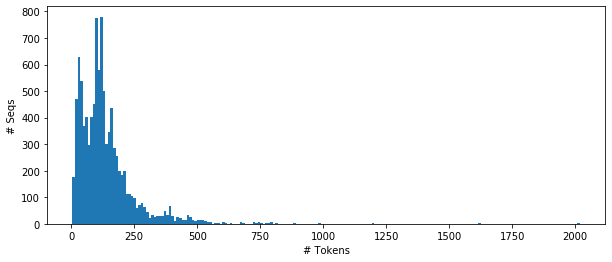

In [63]:
with h5py.File(DATASET_H5_FILE_PATH, 'r') as h5f:
    h5f_group = h5f['protein_tokens']
    all_n_tokens = h5f_group['n_tokens'][:]
    
fig, ax = plt.subplots(figsize = (10, 4))
ax.hist(all_n_tokens, bins = 200)
ax.set_xlabel('# Tokens')
ax.set_ylabel('# Seqs')